In [12]:
import cv2
import numpy as np
import mtcnn
import keras
from keras import models, layers
import tensorflow as tf
import os, time, random, logging
from tqdm.keras import TqdmCallback
import pandas as pd

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [13]:
""" PATH VAR """
base_vigia_dir = "/media/jtstudents/HDD/.zuble/vigia"
weights_base_path = base_vigia_dir+"/zhen++/parameters_saved"
rslt_path = base_vigia_dir+'/zhen++/parameters_results'

#server_testname_folder = '/raid/DATASETS/anomaly/XD_Violence/testing'
server_testname_folder = '/media/jtstudents/HDD/.zuble/xdviol/test'

#server_video_loc = '/home/zhen/Documents/Remote/raid/DATASETS/anomaly/UCF_Crimes/Videos'
#server_video_loc = '/raid/DATASETS/anomaly/XD_Violence/training/'
server_video_loc = '/media/jtstudents/HDD/.zuble/xdviol/train'  


In [14]:
""" TEST/TRAIN FILES """
def test_files(onev = 0):
    """
    GENERATE LIST of TEST FILES
    """
    test_fn, test_normal_fn, test_abnormal_fn = [],[],[]
    y_test_labels, y_test_norm, y_test_abnor = [],[],[]
    
    #all test files
    if onev == 0:
        for root, dirs, files in os.walk(server_testname_folder):
            for file in files:
                if file.find('.mp4') != -1:
                    if 'label_A' not in file:
                        test_normal_fn.append(os.path.join(root, file))
                        y_test_norm.append(0)
                    else:
                        test_abnormal_fn.append(os.path.join(root, file))
                        y_test_abnor.append(1)
                        
        test_fn = test_normal_fn + test_abnormal_fn
        y_test_labels = y_test_norm + y_test_abnor
    #only onev random files
    else :
        test_abn_fn = [x for x in os.listdir(server_testname_folder) if 'label_A' not in x]
        test_nor_fn = [x for x in os.listdir(server_testname_folder) if 'label_A' in x]
        
        onev_abnor = int(onev/2)
        while True: 
            ap = random.choice(test_abn_fn) 
            if ap not in test_fn: 
                test_fn.append(server_testname_folder+"/"+ap)
                y_test_labels.append(1)
                if len(test_fn) == onev_abnor: 
                    break 
        while True: 
            ap = random.choice(test_nor_fn) 
            if ap not in test_fn: 
                test_fn.append(server_testname_folder+"/"+ap)
                y_test_labels.append(0)
                if len(test_fn) == onev: 
                    break    
    
    print("\ntest_fn",np.shape(test_fn),"\ntest_normal_fn",np.shape(test_normal_fn),"\ntest_abnormal_fn",np.shape(test_abnormal_fn))
    print("\ny_test_labels",np.shape(y_test_labels),"\ny_test_norm",np.shape(y_test_norm),"\ny_test_abnor",np.shape(y_test_abnor))
    
    return test_fn, y_test_labels

def train_files():
    """
    GENERATING LIST of TRAIN FILES
    """
    train_fn = []
    
    for root, dirs, files in os.walk(server_video_loc):
        for file in files:
            if file.find('.mp4') != -1:
                train_fn.append(os.path.join(root, file))
                
    print("\ntrain_fn=",np.shape(train_fn))
    
    return train_fn


In [15]:
""" GLOBAL VAR """
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

target_height = 120
target_width = 160
frame_max = 4000

test_fn, y_test_labels = test_files()
train_fn = train_files()

update_index = range(0, len(train_fn))
time_str = str(time.time())
print("\ntime_str=",time_str,"\n")

# =1 last batch has 4000 frames // =2 last batch has no repetead frames
batch_type = 1
print("\n\n\t\tBATCH TYPE",batch_type)


test_fn (800,) 
test_normal_fn (500,) 
test_abnormal_fn (300,)

y_test_labels (800,) 
y_test_norm (500,) 
y_test_abnor (300,)

train_fn= (3954,)

time_str= 1670874934.7674057 



		BATCH TYPE 1


In [16]:
""" INPUT DATA"""
def input_video_data(file_name):
    print("\n\nINPUT_VIDEO_DATA\n")
    #file_name = 'C:\\Bosch\\Anomaly\\training\\videos\\13_007.avi'
    #file_name = '/raid/DATASETS/anomaly/UCF_Crimes/Videos/Training_Normal_Videos_Anomaly/Normal_Videos308_x264.mp4'
    video = cv2.VideoCapture(file_name)
    total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
    mtcnn_detector = mtcnn.mtcnn.MTCNN()
    #print(file_name + '  ' + str(total_frame))
    divid_no = 1
    
    if total_frame > frame_max:
        total_frame_int = int(total_frame)
        if total_frame_int % frame_max == 0:
            divid_no = int(total_frame / frame_max)
        else:
            divid_no = int(total_frame / frame_max) + 1
        
    batch_no = 0
    batch_frames = []
    batch_frames_flip = []
    counter = 0
    if 'Normal' in file_name:
        print("\n\nNORMAL\n\n")
        if divid_no != 1:
            slice_no = int(random.random()*divid_no)
            passby = 0
            if slice_no != divid_no - 1:
                while video.isOpened and passby < frame_max * slice_no:
                    passby += 1
                    success, image = video.read()
                    if success == False:
                        break
            else:
                while video.isOpened and passby < total_frame - frame_max:
                    passby += 1
                    success, image = video.read()
                    if success == False:
                        break

    while video.isOpened:               
        success, image = video.read()
        if success == False:
            break
            
        #ratio = image.shape[0] / image.shape[1]
        #print(str(image.shape[0])+ ' ' + str(image.shape[1]))
        #image = cv2.resize(image, (800, int(800*ratio)))
        #print(image.shape)
        #faces = face_detector.detectMultiScale(image,1.1,8)
        '''
        faces = mtcnn_detector.detect_faces(image)
        
        for face in faces:
            (x,y,w,h) = face['box']
            #print(face)
            cv2.rectangle(image,(x,y), (x+w,y+h), (255,255,0), 2)
            cv2.putText(image, str(face['confidence'])[:4], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 1)
        '''
        image = cv2.resize(image, (target_width, target_height))
        image_flip = cv2.flip(image, 1)
        
        image_array = np.array(image)/255.0
        image_array_flip = np.array(image_flip)/255.0
        
        batch_frames.append(image_array)
        batch_frames_flip.append(image_array_flip)
        
        counter += 1
        if counter > frame_max:
            break
            
    video.release()
    batch_frames = np.array(batch_frames)
    #print(batch_frames.shape)
        
    return np.expand_dims(batch_frames,0), np.expand_dims(batch_frames_flip, 0), total_frame

def generate_input():
    #has_visited = [0 for i in range(len(train_fn))]
    
    print("\n\nGENERATE_INPUT\n")
    loop_no = 0
    while 1:
        index = update_index[loop_no]
        loop_no += 1
        if loop_no == len(train_fn):
            loop_no = 0
            
        #index = 0
        batch_frames, batch_frames_flip, total_frames = input_video_data(train_fn[index])
        print("\ntrain_fn[",index,"]=",train_fn[index],"\ntotal_frames=",total_frames,"\nbatch_frames.shape=",batch_frames.shape)
        #if batch_frames.ndim != 5:
        #   break
        
        # GENERATORS    
        #       a kind of iterators that can only iterate over once
        #       NO store of values in memory
        # YIELD 
        #       like a return, except the function will return a generator
        
        '''
        if 'Abuse' in train_fn[index]:
            yield batch_frames,  np.array([np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Arrest' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Arson' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Assault' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0])]) 
        elif 'Burglary' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0])]) 
        elif 'Explosion' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0])])        
        elif 'Fighting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0])]) 
        elif 'RoadAccidents' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0])]) 
        elif 'Robbery' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0])]) 
        elif 'Shooting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0])]) 
        elif 'Shoplifting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0])]) 
        elif 'Stealing' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0])])
        elif 'Normal' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0])]) 
        elif 'Vandalism' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1])]) 
        '''
        
        #batch_frames
        if 'label_A' in train_fn[index]:
            yield batch_frames, np.array([0])   #normal
        else:
            yield batch_frames, np.array([1])   #abnormal

        #batch_frames_flip
        if 'label_A' in train_fn[index]:
            yield batch_frames_flip, np.array([0])  #normal
        else:
            yield batch_frames_flip, np.array([1])  #abnormal
    
    print("loop_no=",loop_no)

def input_test_video_data(file_name, batch_no=0):
    #file_name = 'C:\\Bosch\\Anomaly\\training\\videos\\13_007.avi'
    #file_name = '/raid/DATASETS/anomaly/UCF_Crimes/Videos/Training_Normal_Videos_Anomaly/Normal_Videos308_x264.mp4'
    video = cv2.VideoCapture(file_name)
    total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    #mtcnn_detector = mtcnn.mtcnn.MTCNN()
    divid_no = 1

    if total_frame > frame_max:
        total_frame_int = int(total_frame)
        if total_frame_int % frame_max == 0:
            divid_no = int(total_frame / frame_max)
        else:
            divid_no = int(total_frame / frame_max) + 1


    #updates the start frame to 0,4000,8000... excluding the last batch
    passby = 0
    if batch_no != divid_no - 1:
        while video.isOpened and passby < frame_max * batch_no:
            passby += 1
            success, image = video.read()
            if success == False:
                break
            
    #updates the last batch starting frame 
    else:
        if batch_type==1:
            #print("1")
            while video.isOpened and passby < total_frame - frame_max:
                passby += 1
                success, image = video.read()
                if success == False:
                    break
        #last batch must have >= 400 otherwise it falls back to batch_type 1
        if batch_type==2 and total_frame - (frame_max * batch_no) >= frame_max*0.1:
            #print("2")
            while video.isOpened and passby < frame_max * batch_no:
                passby += 1
                success, image = video.read()
                if success == False:
                    break
        else:
            while video.isOpened and passby < total_frame - frame_max:
                passby += 1
                success, image = video.read()
                if success == False:
                    break

            
    batch_frames, batch_imgs = [], []
    counter = 0
    
    while video.isOpened:               
        success, image = video.read()
        if success == False:
            break
        batch_imgs.append(image)
        
        image_rsz = cv2.resize(image, (target_width, target_height))
        image_array = np.array(image_rsz)/255.0 #normalize
        batch_frames.append(image_array)
        
        counter += 1
        if counter > frame_max:
            break
            
    video.release()
    batch_frames = np.array(batch_frames)
    
    print("\t-batch",batch_no,"[",passby,", ... ] ",batch_frames.shape)    
    
    return np.expand_dims(batch_frames,0), batch_imgs, divid_no, total_frame, passby, fps

def watch_test(predict_total,test_files):
    global is_quit, is_paused, frame_counter
    for k in range(len(test_files)):
        
        file_path = test_files[k]
        video = cv2.VideoCapture(str(file_path))
        
        window_name = "anoml vwr"+str(k)+":"+file_path.replace('/media/jtstudents/HDD/.zuble/xdviol/test','')
        cv2.namedWindow(window_name)
        
        # Video information
        fps = video.get(cv2.CAP_PROP_FPS)
        width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
        total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # We can set up keys to pause, go back and forth.
        # **params can be used to pass parameters to key actions.
        def quit_key_action(**params):
            global is_quit
            is_quit = True
        def rewind_key_action(**params):
            global frame_counter
            frame_counter = max(0, int(frame_counter - (fps * 5)))
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        def forward_key_action(**params):
            global frame_counter
            frame_counter = min(int(frame_counter + (fps * 5)), total_frame - 1)
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        def pause_key_action(**params):
            global is_paused
            is_paused = not is_paused
        # Map keys to buttons
        key_action_dict = {
            ord('q'): quit_key_action,
            ord('a'): rewind_key_action,
            ord('d'): forward_key_action,
            ord('s'): pause_key_action,
            ord(' '): pause_key_action
        }
        def key_action(_key):
            if _key in key_action_dict:
                key_action_dict[_key]()
                
        prev_time = time.time() # Used to track real fps
        is_quit = False         # Used to signal that quit is called
        is_paused = False       # Used to signal that pause is called
        
        frame_counter = 0       # Used to track which frame are we.
        batch_in_video = predict_total[k][0]
        predict_atual = ()
        try:
            while video.isOpened():
                # If the video is paused, we don't continue reading frames.
                if is_quit:
                    # Do something when quiting
                    break
                elif is_paused:
                    # Do something when paused
                    pass
                else:
                    sucess, frame = video.read() # Read the frames
                    if not sucess:break

                    frame_counter = int(video.get(cv2.CAP_PROP_POS_FRAMES))
                                        
                    if batch_in_video == 1: predict_atual = predict_total[k][2]
                    #(2, 4001, 0.99958295, 661, 4661, 0.98756117))
                    if batch_in_video == 2:
                        #<661 as=0.999
                        if frame_counter < predict_total[k][3]: predict_atual = predict_total[k][2]
                        # > 661 and < 4000 as: 0.999 | 0.987
                        elif frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2] , predict_total[k][5]
                        # > 4000 as: 0.987
                        else: predict_atual = predict_total[k][5]
                    #(3, 4001, 0.99958295, 4001, 8000, 0.98756117,4500,8500,0.836))
                    if batch_in_video == 3:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #< 4500 as=0.987
                        elif frame_counter < predict_total[k][6]: predict_atual = predict_total[k][5]
                        #< 8000 as=0.987 | 0.836
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5] , predict_total[k][8]
                        # > 8000 as=0.836
                        else:predict_atual = predict_total[k][8]
                    #(4, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 8500,12500,0.888))    
                    if batch_in_video == 4:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 8500 as=0.836
                        elif frame_counter < predict_total[k][9]: predict_atual = predict_total[k][8]
                        #< 12000 as=0.836 / 0.888
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8] , predict_total[k][11]
                        # > 8000 as=0.836
                        else:predict_atual = predict_total[k][11]
                    #(5, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 12500,16500,0.777))
                    if batch_in_video == 5:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #< 12500 as=0.888
                        elif frame_counter < predict_total[k][12]: predict_atual = predict_total[k][11]
                        #<16000 as:0.888 | 0.777
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11] , predict_total[k][14]
                        # >16000 as=0.777
                        else:predict_atual = predict_total[k][14]
                    #(6, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 16000,20000,0.777, 16500,20500,0.5))
                    if batch_in_video == 6:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.888
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<16500 as:0.777
                        elif frame_counter < predict_total[k][15]: predict_atual = predict_total[k][14]
                        #<20000 as:0.777 | 0.5
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14] , predict_total[k][17]
                        #>20000 as=0.5
                        else:predict_atual = predict_total[k][17]
                    #(7, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 16000,20000,0.777, 20000,24000,0.5, 20500,24500,0.6))
                    if batch_in_video == 7:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.888
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<20000 as=0.777
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14]
                        #<20500 as:0.5
                        elif frame_counter < predict_total[k][18]: predict_atual = predict_total[k][17]
                        #<24000 as:0.5 | 0.6
                        elif frame_counter < predict_total[k][16]: predict_atual = predict_total[k][17] , predict_total[k][20]
                        #>24000 as=0.6
                        else:predict_atual = predict_total[k][20]
                    #(8, 4001,0.2, 4001,8000,0.5, 8000,12000,0.8, 12000,16000,0.11, 16000,20000,0.14, 20000,24000,0.17, 24000,28000,0.20, 24500.28500,0.23))
                    if batch_in_video == 8:
                        #<4000 as=0.2
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.5
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.8
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.11
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<20000 as=0.14
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14]
                        #<24000 as:0.17
                        elif frame_counter < predict_total[k][16]: predict_atual = predict_total[k][17]
                        #<24500 as:0.20
                        elif frame_counter < predict_total[k][21]: predict_atual = predict_total[k][20]
                        #<28000 as:0.20 | 0.23
                        elif frame_counter < predict_total[k][19]: predict_atual = predict_total[k][20] , predict_total[k][23]
                        #>28000 as=0.23
                        else:predict_atual = predict_total[k][23]                    
                    
                    
                    '''
                    for current frame, check all visible items
                    if str(frame_counter) in data_frames:
                        for item in data_frames[str(frame_counter)]:
                            item_id = item['visibleObjectId']
                            color = colormap.get_color(item_id)
                        
                            # for visible item, get position at current frame and paint rectangle in
                            if frame_counter in data_objects[item_id]:
                                bbox = data_objects[item_id][frame_counter]['rectangle']
                                x1 = bbox[0]['x']
                                y1 = bbox[0]['y']
                                x2 = x1 + bbox[0]['w']
                                y2 = y1 + bbox[0]['h']
                                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                                cv2.putText(frame, str(item_id[:3]), (x1, y1-10), font, 0.5, color, 2)
                    '''
                    
                    print(predict_atual)
                    
                    # Display frame numba/AS/time/fps
                    cv2.putText(frame, 'Frame: %d' % (frame_counter), (10, 10), font, 0.5, [60,250,250], 2)
                    cv2.putText(frame, 'AS:'+str(predict_atual), (10, 30), font, 0.5, [80,100,250], 2)
                    
                    cv2.putText(frame, 'Time: %.4f' % (frame_counter/fps), (int(width*2/8), 10), font, 0.5, [100,250,10], 2)
                    new_time = time.time()
                    cv2.putText(frame, 'fps: %.2f' % (1/(new_time-prev_time)), (int(width*4/8), 10), font, 0.5, [0,50,200], 2)
                    prev_time = new_time
                    
                # Display the image
                cv2.imshow(window_name,frame)

                # Wait for any key press and pass it to the key action
                frame_time_ms = int(1000/fps)
                key = cv2.waitKey(frame_time_ms)
                key_action(key)
                
        finally:
            video.release()
            cv2.destroyAllWindows()

    file_number =+ 1


In [17]:
""" MODEL """

def all_operations(args):
    x = args[0]
    #tf.print(x.shape)
    x = tf.reshape(x, [1, -1,x.shape[1]*x.shape[2]*x.shape[3]])
    return x
@tf.function
def loss_category(y_true, y_pred):    
    #tf.print(y_pred, y_true, 'Prediction')
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return cce


def find_weights(): 
    weights_fn = []
    weights_path = []

    for file in os.listdir(weights_base_path):
        fname, fext = os.path.splitext(file)
        if fext == ".h5" and file.find('_2_4_8_xdviolence_model_weights') != -1 :
            print(file)
            weights_path.append(os.path.join(weights_base_path, file))
            weights_fn.append(file)

    return weights_fn, weights_path


def form_model():
    print("\nFORM_MODEL\n")
    image_input = keras.Input(shape=(None, target_height, target_width, 3))
    #Freeze the batch normalization
    
    c3d_layer1 = keras.layers.Conv3D(4,(2,3,3), activation='relu')(image_input)
    c3d_pooling1 = keras.layers.MaxPooling3D((1,2,2))(c3d_layer1)
    c3d_layer2 = keras.layers.Conv3D(8,(4,3,3), activation='relu')(c3d_pooling1)
    c3d_pooling2 = keras.layers.MaxPooling3D((2,2,2))(c3d_layer2)
    c3d_layer3 = keras.layers.Conv3D(16,(8,3,3), activation='relu')(c3d_pooling2)
    c3d_pooling3 = keras.layers.MaxPooling3D((4,2,2))(c3d_layer3)
    #c3d_layer4 = keras.layers.Conv3D(32,(2,3,3), activation='relu')(c3d_pooling3)
    #c3d_pooling4 = keras.layers.MaxPooling3D((2,2,2))(c3d_layer4)
    
    feature_conv_4 = keras.layers.Lambda(all_operations)(c3d_pooling3)
    
    lstm1 = keras.layers.LSTM(1024,input_shape=(1200,feature_conv_4.shape[2]), return_sequences=True)(feature_conv_4)
    lstm2 = keras.layers.LSTM(512, return_sequences=True)(lstm1)
    global_feature = keras.layers.GlobalMaxPooling1D()(lstm1)
    
    #ADD THE AUDIO FEATURE HERE 
    
    dense_1 = keras.layers.Dense(128, activation='relu')(global_feature)
    #dense_2 = keras.layers.Dense(13, activation='sigmoid')(dense_1)
    
    
    soft_max = keras.layers.Dense(1, activation='sigmoid')(dense_1)
    
    
    model = models.Model(inputs=[image_input], outputs=[soft_max])
    model.summary()
    
    
    #class_weights = [10,10,10,10,10,10,10,10,10,10,10,10,0.1,10]
    optimizer_adam = keras.optimizers.SGD(learning_rate = 0.0002)
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    model.compile(optimizer=optimizer_adam, 
                    loss= 'binary_crossentropy', 
                    #loss_weights = class_weights,
                    #metrics=['accuracy']
                    metrics=METRICS)
    return model


def train_model():
    '''
    MODEL TRAIN/VALIDATION 
    (silent mode - verbose = 0)
    '''

    #https://keras.io/api/callbacks/model_checkpoint/
    ckpt_path = base_vigia_dir+'/zhen_++/'+time_str+'_2_4_8_xdviolence_anomaly_{epoch:08d}.h5'
    checkpoint = keras.callbacks.ModelCheckpoint(ckpt_path, save_freq='epoch')

    #para_file_name = '.262731_2_4_8_xdviolence_anomaly_00000010.h5'
    #model.load_weights(para_file_name)

    print("\n\nMODEL.FIT")
    history = model.fit(generate_input(), 
                        steps_per_epoch=len(train_fn)*2, 
                        epochs=30, 
                        verbose=1, 
                        callbacks=[checkpoint, TqdmCallback(verbose=2)])

    model.save(time_str + '_2_4_8_xdviolence')
    model.save_weights(time_str + '_2_4_8_xdviolence_model_weights.h5')  

    hist_df = pd.DataFrame(history.history)
    hist_csv_file = time_str + '_xdviolence_history.csv'
    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)
        
    return model


def test_model(model):
    print("\nTEST MODEL\n")
    f = open(base_vigia_dir+'/zhen++/parameters_results/'+model_weight_fn+'_'+str(batch_type)+'.txt', 'w')
    content_str = ''
    total_frames_test = 0
    predict_total= [] 
    
    start_test = time.time()
    for i in range(len(test_fn)):
        if test_fn[i] != '':
            file_path = test_fn[i]
            
            #the frist 4000 frames from actual test video                
            batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path)
            video_time = total_frames/fps
            total_frames_test += total_frames
            
            start_predict1 = time.time()
            predict_result = model.predict(batch_frames)[0][0]
            end_predict1 = time.time()
            time_predict = end_predict1-start_predict1
            
            high_score_patch = 0
            print("\t ",predict_result,"%") 
            
            
            #when batch_frames (input video) has > 4000 frames
            patch_num = 1
            while patch_num < divid_no:
                batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path, patch_num)
                
                start_predict2 = time.time()
                predict_new = model.predict(batch_frames)[0][0]
                end_predict2 = time.time()
                time_predict += end_predict2 - start_predict2
                
                if predict_new > predict_result:
                    predict_result = predict_new
                    high_score_patch = patch_num
                    
                print("\t ",predict_result,"%")  
                patch_num += 1
                
            predict_total.append(predict_result)
            
            if 'label_A' in test_fn[i]:
                print('\nNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        test_fn[i][test_fn[i].rindex('/')+1:],
                        "\n\t "+str(predict_result),"% @batch",high_score_patch,"in",str(time_predict),"seconds\n",
                        "----------------------------------------------------\n")
            else:
                print('\nABNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        test_fn[i][test_fn[i].rindex('/')+1:],
                        "\n\t"+str(predict_result),"% @batch",high_score_patch,"in",str(time_predict),"seconds\n",
                        "----------------------------------------------------\n")
                
            content_str += test_fn[i][test_fn[i].rindex('/')+1:] +'|'+ str(predict_result)  + '\n'
    
    end_test = time.time()
    time_test = end_test - start_test

    f.write(content_str)
    f.close()
    print("\nDONE\n\ttotal of",str(total_frames_test),"frames processed in",time_test," seconds",
            "\n\t"+str(total_frames_test / time_test),"frames per second",
            "\n\n********************************************************",
            "\n\n********************************************************")                  

    return predict_total

def test_model_1V(model):
    print("\nTEST MODEL MINI\n")
    f = open(rslt_path+'/1V/'+model_weight_fn+'_'+str(batch_type)+'.txt', 'w')
    content_str = ''
    total_frames_test = 0
    
    predict_total = [] #to output predict in vizualizer accordingly to the each batch prediction
    predict_max = 0 #to print the max predict related to the file in test
    predict_total_max = [] #to perform the metrics
    
    start_test = time.time()
    for i in range(len(onev_fn)):
        if onev_fn[i] != '':
            file_path = onev_fn[i]
            predict_result = () #to save predictions per file
            
            #the frist 4000 frames from actual test video                
            batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path)
            video_time = total_frames/fps
            total_frames_test += total_frames
            
            #prediction on frist batch
            start_predict1 = time.time()
            predict_aux = model.predict(batch_frames)[0][0]
            end_predict1 = time.time()
            time_predict = end_predict1-start_predict1
            
            predict_max = predict_aux
            predict_result = (divid_no,start_frame+batch_frames.shape[1],predict_max)
            #print(predict_result,batch_frames.shape)
            
            high_score_patch = 0
            print("\t ",predict_max,"%") 
            
            #when batch_frames (input video) has > 4000 frames
            patch_num = 1
            while patch_num < divid_no:
                batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path, patch_num)
                
                #nésimo batch prediction
                start_predict2 = time.time()
                predict_aux = model.predict(batch_frames)[0][0]
                end_predict2 = time.time()
                time_predict += end_predict2 - start_predict2

                if predict_aux > predict_max:
                    predict_max = predict_aux
                    high_score_patch = patch_num
                
                predict_result += (start_frame,start_frame+batch_frames.shape[1], predict_aux)
                #print(predict_result,batch_frames.shape)
                
                print("\t ",predict_aux,"%")  
                patch_num += 1
            
            predict_total.append(predict_result)
            predict_total_max.append(predict_max)
            print(predict_total[i])
            
            if 'label_A' in onev_fn[i]:
                print('\nNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        onev_fn[i][onev_fn[i].rindex('/')+1:],
                        "\n\t "+str(predict_max),"% @batch",high_score_patch,"in",str(time_predict),"seconds\n",
                        "----------------------------------------------------\n")
            else:
                print('\nABNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        onev_fn[i][onev_fn[i].rindex('/')+1:],
                        "\n\t"+str(predict_max),"% @batch",high_score_patch,"in",str(time_predict),"seconds\n",
                        "----------------------------------------------------\n")
                
            content_str += onev_fn[i][onev_fn[i].rindex('/')+1:] + '|' + str(predict_total_max[i]) + '|' + str(predict_total[i])  + '\n'
            
    end_test = time.time()
    time_test = end_test - start_test

    f.write(content_str)
    f.close()
    print("\nDONE\n\ttotal of",str(total_frames_test),"frames processed in",time_test," seconds",
            "\n\t"+str(total_frames_test / time_test),"frames per second",
            "\n\n********************************************************",
            "\n\n********************************************************")                  

    return predict_total_max, predict_total


In [18]:
""" METRICS
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data """

def plot_cm(name,labels,predictions,p=0.5):
    '''
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#download_the_kaggle_credit_card_fraud_data_set
    '''
    predictions = np.array(predictions)
    cm = confusion_matrix(labels, predictions > p)
    #plt.clf()
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(name+'.png',facecolor='white', transparent=False)
    plt.show()

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,80])
    plt.ylim([20,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig(name+'.png',facecolor='white', transparent=False)
    plt.show()
    
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    #plt.clf()
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([-0.5,100.5])
    plt.ylim([-0.5,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig(name+'.png',facecolor='white', transparent=False)
    plt.show()

def get_precision_recall_f1(labels, predictions):
    p = tf.keras.metrics.Precision(thresholds = 0.5)
    p.update_state(labels, predictions)
    p_res = p.result().numpy()
    print("\tPRECISION (%% of True Positive out of all Positive predicted) ",p_res)
    
    r = tf.keras.metrics.Recall(thresholds=0.5)
    r.update_state(labels, predictions)
    r_res = r.result().numpy()
    print("\tRECALL (%% of True Positive out of all existing anomalie) ",r_res)
    
    #https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
    #f1 = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    #f1.update_state(labels, predictions)
    #f1_res = f1.result().numpy()
    #print("\tF1_SCORE (harmonic mean of precision and recall) ",f1_res)
    
    return p_res,r_res#,f1_res


In [19]:
''' GPU CONFIGURATION
    https://www.tensorflow.org/guide/gpu '''

def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)

set_tf_loglevel(logging.WARNING)

#Enabling device placement logging causes any Tensor allocations or operations to be printed.
tf.debugging.set_log_device_placement(False) 

#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
gpus = tf.config.list_physical_devices('GPU')


#https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

#if gpus:
#    print("\nAvaiable GPU's",gpus)
#    try:
#        # Currently, memory growth needs to be the same across GPUs
#        for gpu in gpus:
#            tf.config.experimental.set_memory_growth(gpu, True)
#        
#        logical_gpus = tf.config.list_logical_devices('GPU')
#        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#    except RuntimeError as e:
#        # Memory growth must be set before GPUs have been initialized
#        print(e)

In [20]:
""" TEST ZHEN .h5 WEIGHTS FILES """

def test_zhen_wghts():
    
    print("\n\n\t\tBATCH TYPE",batch_type)
        
    for i in range(len(weights_fn)):
        print("\n\nLoading weights from",weights_fn[i],"\n")
        model.load_weights(weights_path[i])
        model_weight_fn,model_weight_ext = os.path.splitext(str(weights_fn[i]))
        
        y_test_pred = test_model(model)
        
        plot_cm(rslt_path+'/orignal_bt/'+model_weight_fn+'_CM'+str(batch_type),y_test_pred)
        plot_roc(rslt_path+'/orignal_bt/'+model_weight_fn+'_ROC'+str(batch_type), y_test_labels , y_test_pred, color=colors[0], linestyle='--')
        plot_prc(rslt_path+'/orignal_bt/'+model_weight_fn+'_PRC'+str(batch_type), y_test_labels, y_test_pred, color=colors[0])
        
def get_results_from_txt():
    path = rslt_path + '/1V/'
    res_txt_fn = []
    res_model_fn = []
    
    for file in os.listdir(path):
        fname, fext = os.path.splitext(file)
        if fext == ".txt" and file.find('xdviolence') != -1:
            res_txt_fn.append(os.path.join(path, file))
            res_model_fn.append(fname)
    
    res_txt_fn = sorted(res_txt_fn)
    res_model_fn = sorted(res_model_fn)
    
    res_list = [[0 for i in range(len(res_txt_fn))] for j in range(800)]
    
    for i in range(len(res_txt_fn)):
        print('OPENING',res_txt_fn[i])
        txt = open(res_txt_fn[i],'r')
        txt_data = txt.read()
        txt.close()
        
        txt_list = [line.split() for line in txt_data.split("\n") if line]
        
        for j in range(len(txt_list)):
            #print(txt_list[j][1]," ")
            res_list[j][i] = float(txt_list[j][1])
            
    for i in range(len(res_txt_fn)):
        print("\nresults for",res_model_fn[i])
            
        res_col = [col[i] for col in res_list]
        get_recall(res_col)
        get_precision(res_col)
        
    return res_list

#model = form_model()
#weights_fn, weights_path = find_weights()
#test_zhen_wghts()

#res_list = get_results_from_txt()


FORM_MODEL

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 120, 160, 3) 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, None, 118, 158, 4) 220       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, None, 59, 79, 4)   0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, None, 57, 77, 8)   1160      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, None, 28, 38, 8)   0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, None, 26, 36, 16)  9232      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, None, 13, 

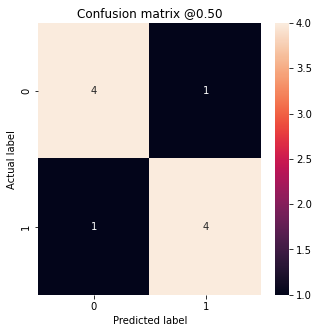

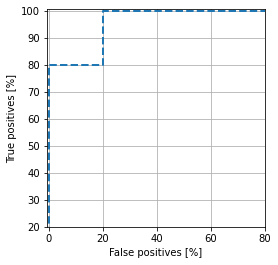

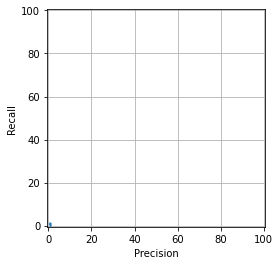

	PRECISION (%% of True Positive out of all Positive predicted)  0.8
	RECALL (%% of True Positive out of all existing anomalie)  0.8


In [21]:
""" test onev """
model = form_model()
weights_fn, weights_path = find_weights()

onev_fn, y_onev_labels = test_files(10)

# =1 last batch has 4000 frames // =2 last batch has no repetead frames
#batch_type = 2

'''for i in range(len(weights_fn)):'''
for i in range(1):
    print("\n\nLoading weights from",weights_fn[i],"\n")
    model.load_weights(weights_path[i])
    model_weight_fn,model_weight_ext = os.path.splitext(str(weights_fn[i]))
    
    y_test_pred, predict_total = test_model_1V(model)
    plot_cm(rslt_path+'/1V/'+model_weight_fn+'_CM'+str(batch_type),y_onev_labels, y_test_pred)
    plot_roc(rslt_path+'/1V/'+model_weight_fn+'_ROC'+str(batch_type), y_onev_labels , y_test_pred, color=colors[0], linestyle='--')
    plot_prc(rslt_path+'/1V/'+model_weight_fn+'_PRC'+str(batch_type), y_onev_labels, y_test_pred, color=colors[0])
    get_precision_recall_f1(y_onev_labels, y_test_pred)
    #watch_test(predict_total,onev_fn)

In [22]:
#watch_test(predict_total,onev_fn)